Game Plan:
1. Show that the choice of outcome variable does not matter very much because of the extremely high correlation between potential outcomes.
    - Create a nice looking correlation plot for the outcomes
    -  Probably try to create the sns.pairplot() although that function was very very slow
2.  Point out that the Spotify playlists are MUCH more successful than the typical user playlist
    - Can show that by plotting bar charts next to each other, group by whether owner == "spotify"
3.  Have to make a decision on what outcome variable to choose (or most likely a combination of outcome variables!)
4.  Look at univariate cuts of the outcome variable(s) with the predictors, just to try to give a sense of the relationship between the variables prior to modeling
5.  Build a baseline model that we can use for prediction and then we can compare this to a more advanced model -- will allow for simpler interpretations
6.  Build an ML model that we can then go compare efficacy with the baseline model.

Note: 
1.  We will likely want to run separate analyses broken out by owner == 'spotify' vs owner != 'spotify'
    a.  See if the importance of the other predictors is comparable for the two groups
2.  If a user streams 2 or more songs consecutively, does that count as 2 streams or only 1 since the stream were consecutive? 


Possible Options (no particular order)
1.  Look into multivariate methods to accommodate the various potential outcome variables (or could just pick one/create a PCA)
2.  Should probably think through how to use the 'skippers' data.  Could this be at all helpful in dealing with potential biases in how Spotify may promote playlists? 

Assumptions:
1.  This is a random sample of playlists.  If this a biased sample, then any generalizations that we make from the data is likely to be meaningfully inaccurate.
2.  Spotify treats each non-Spotify playlist equally in terms of promotion.  For examples, if the Spotify algorithms were promoting some genres above others at the time this data was collected, then we are unlikely to get a good read on how genre affects listenership.   
3.  (a) Spotify treats its own playlists differently than the non-Spotify playlists.  If this assumption is correct, then it is likely that Spotify playlists are not particularly comparable to non-Spotify playlists.  
    (b) Spotify treats its own playlists equally with each other.  Thus, an analysis with only Spotify playlists should be okay.  
4.  Each playlist included in the dataset has existed for at least two months.  This ensures that the monthly average users in the previous month variable is not biased by how long the playlist has existed.
5.  The Spotify algorithms do not amplify small variations in success.  If playlist A was slightly more successful than Playlist B two months ago under 'fair' algorithmic treatment, then the algorithms will not amplify playlist A over playlist B, and thus widen the gulf between the success of the two playlists.  In other words, there is a fair marketplace for the playlists to compete, where success does not necessarily beget success simply due to the algorithms.  

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
pd.set_option('display.max_columns', None)

In [54]:
raw_data = pd.read_table('data/playlist_summary_external.txt')
spotify_data = raw_data.query('owner == "spotify"')
nonspotify_data = raw_data.query('owner != "spotify"')
outcome_vars = ['streams', 
                'stream30s', 
                'dau', 
                'wau', 
                'mau', 
                'mau_previous_month',
                'mau_both_months',
                'users',
                'monthly_stream30s',
               ]
predictor_vars = ['n_tracks', 
                 'n_local_tracks',
                  'n_artists',
                  'n_albums',
                  'genre_1',
                  'genre_2',
                  'genre_3',
                  'mood_1',
                  'mood_2',
                  'mood_3'
                 ]

# Introduction

The data under consideration for these analyses consists of 403,366 distinct playlists, with 314,899 distinct playlist owners.  Of the 314,899 unique playlist owners, 261,040 (83%) have exactly one playlist in the data.  Of the owners with more than one playlist, Spotify itself has the most, with 399.  The data is composed of only playlists from US owners, and thus extrapolating any of these analyses to other countries is likely unwarranted or should be done with great caution.  Each playlist is categorized by its top three genres and top three moods.  There are 26 genres and 27 moods under consideration.

There are a number of potential measures of playlist success included in this dataset.  Specifically, we have (1) The number of streams from the playlist today, (2) the number of streams greater than 30 seconds today, (3) the number of active users today, where an active user is defined as having a stream $>30$ seconds, (4) the number of active users in the past week, (5) the number of active users in the past month, (6) the number of users who had a stream this playlist for any length of time in the past month, (7) the number of active users in the previous month, (8) the total number of $>30$ second streams in the past month, (9) the number of users who were active this month and the previous month, and (10) the number of $>30$ second streams by the playlist owner in the past month.  The data also includes the number of users who skipped more than 90% of their total streams today who also used this playlist, which could be used as a reverse encoded outcome variable.  

Some of the potential predictors of stream success include: (1) the number of tracks in the playlist, (2) the number of tracks that were added to the playlist today, (3) The number of unique artists in the playlist, (4) the number of unique albums in the playlist, (5-7) the first, second and third most common genre found in the playlist, (8-10) the first, second and third most common mood found in the playlist, and (11) the tokens associated with the playlist.

## Comparing Spotify-Owned and Non-Spotify-Owned Playlists

There is a wide gulf between the Spotify-owned and non-Spotify-owned playlists.  To illustrate this, consider the plot below of 

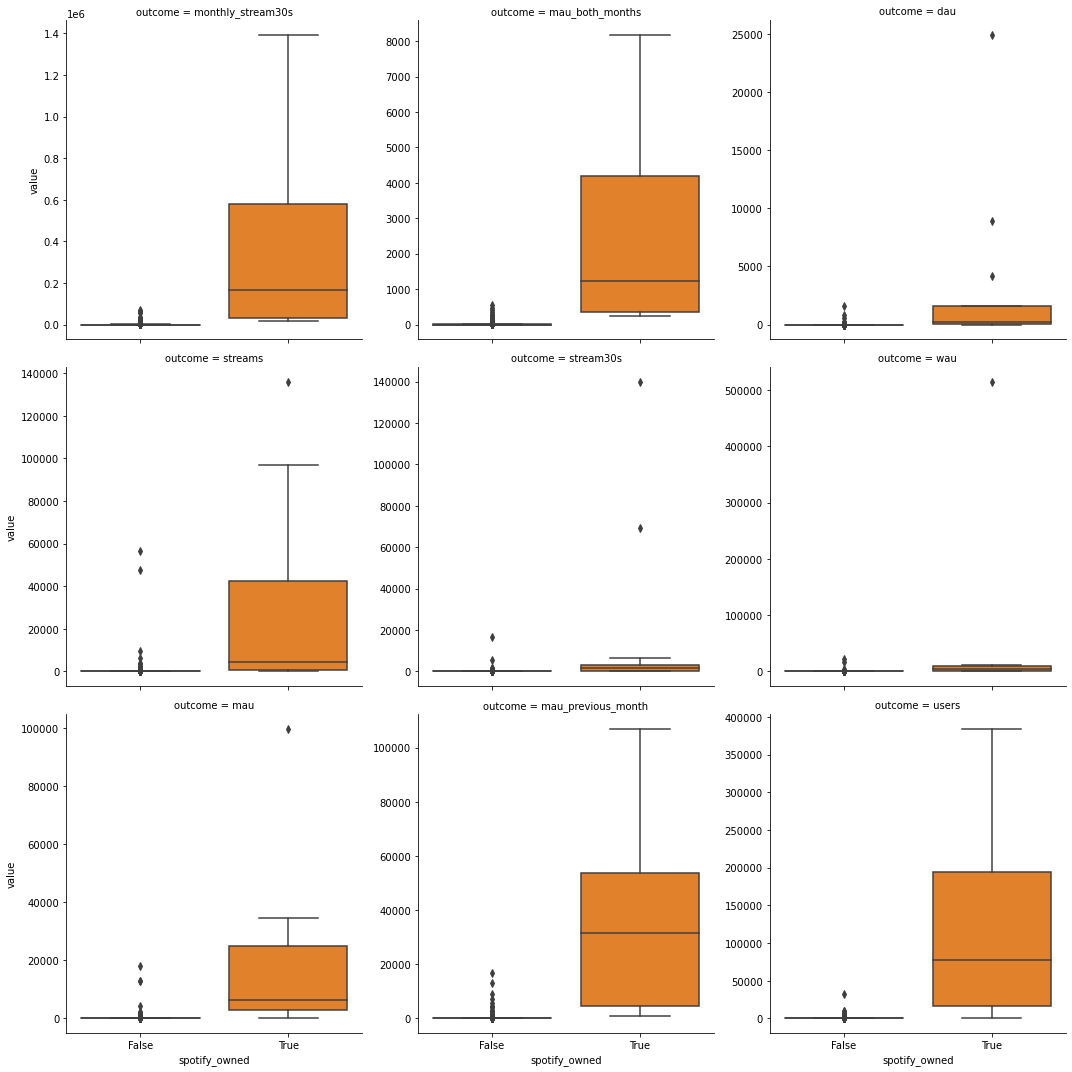

In [66]:
raw_data['spotify_owned'] = raw_data['owner'] == 'spotify'
comparison_data = (raw_data.
                   loc[:, ['spotify_owned'] + outcome_vars].
                   melt(id_vars = 'spotify_owned',
                       var_name = 'outcome',
                       value_name = 'value')
                  )
test_data = comparison_data.sample(100000)
sns.catplot(data = test_data,
            kind = 'box',
            col = 'outcome',
            col_wrap = 3,
            sharey = False,
            y = 'value', 
            x = 'spotify_owned')

In [65]:
?sns.catplot

Signature:
sns.catplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    row=None,
    col=None,
    col_wrap=None,
    estimator=<function mean at 0x00000211ECCF2AF0>,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=None,
    hue_order=None,
    row_order=None,
    col_order=None,
    kind='strip',
    height=5,
    aspect=1,
    orient=None,
    color=None,
    palette=None,
    legend=True,
    legend_out=True,
    sharex=True,
    sharey=True,
    margin_titles=False,
    facet_kws=None,
    **kwargs,
)
Docstring:
Figure-level interface for drawing categorical plots onto a FacetGrid.

This function provides access to several axes-level functions that
show the relationship between a numerical and one or more categorical
variables using one of several visual representations. The ``kind``
parameter selects the underlying axes-level function to use:

Categorical scatterplots:

- :func:`stripplot` (with ``kind="strip"``; the default)
- :func:`swarmplo

## Exploration of Potential Outcomes

In results not shown, the correlation between the number of $>30$ second streams by the playlist owner is *much* more weakly correlated with the other potential outcome variables than, and thus will not be included in the following analysis.  

To begin understanding the relationship between the potential outcomes of interest, we present a heatmap of the Pearson correlation between each of the outcomes.  We create one such heatmap for the non-Spotify-owned playlists and another for the Spotify-owned playlists.  Amongst the non-Spotify-owned playlists, we see that the minimum correlation between any of the outcomes is 0.78, thus signifying a great deal of correlation between our potential outcomes.  While all potential outcomes are highly correlated, the mostly weakly correlated outcomes are the outcomes related to playlists' longer-term success (i.e. the monthly average users in the given month and the previous month) with the more recent measures of success (i.e. the number of total and >30 second streams today and the number of active users today and in the past week)  Amongst the Spotify-owned playlists, the potential outcomes are even more highly correlated, with the smallest correlation being 0.91.  The Spotify-owned playlists exhibit a similar general pattern to those of the non-Spotify-owned in that the weakest correlation between the outcomes is between the more long-term measures of success and the measures of success in the more recent past.  However, the degree of correlation is still immense between monthly active users over the past two months and the number of streams that occurred today, thus indicating that Spotify playlists tend to have considerable 'staying power'.  Of course, if more successful playlists in the past are algorithmically pushed to users, then this could become a self-fulfilling prophecy rather than a true indication of how 'intrinsically good' the palylist is.  

In [39]:
def plot_outcome_corr(data):
    plot_data = data.loc[:, outcome_vars]
    plot_data_corr = plot_data.corr()
    return plot_data, sns.heatmap(plot_data_corr, annot = True, cmap = 'BrBG')

Text(0.5, 1.0, 'Correlation Heatmap of Potential Outcome Variables for the non-Spotify-owned Playlists')

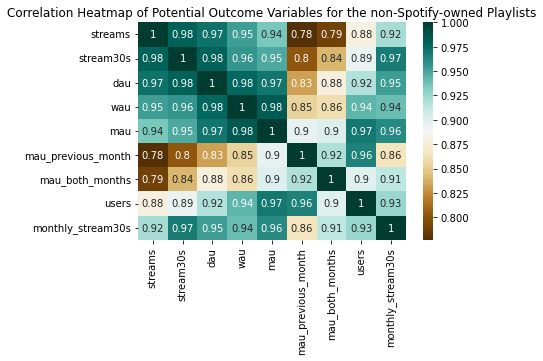

In [40]:
nonspotify_outcome_data, nonspotify_heatmap = plot_outcome_corr(nonspotify_data)
nonspotify_heatmap.set_title('Correlation Heatmap of Potential Outcome Variables for the non-Spotify-owned Playlists')

Text(0.5, 1.0, 'Correlation Heatmap of Potential Outcome Variables for the Spotify-owned Playlists')

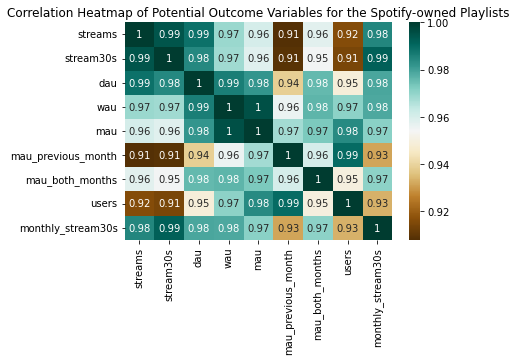

In [41]:
spotify_outcome_data, spotify_heatmap = plot_outcome_corr(spotify_data)
spotify_heatmap.set_title('Correlation Heatmap of Potential Outcome Variables for the Spotify-owned Playlists')

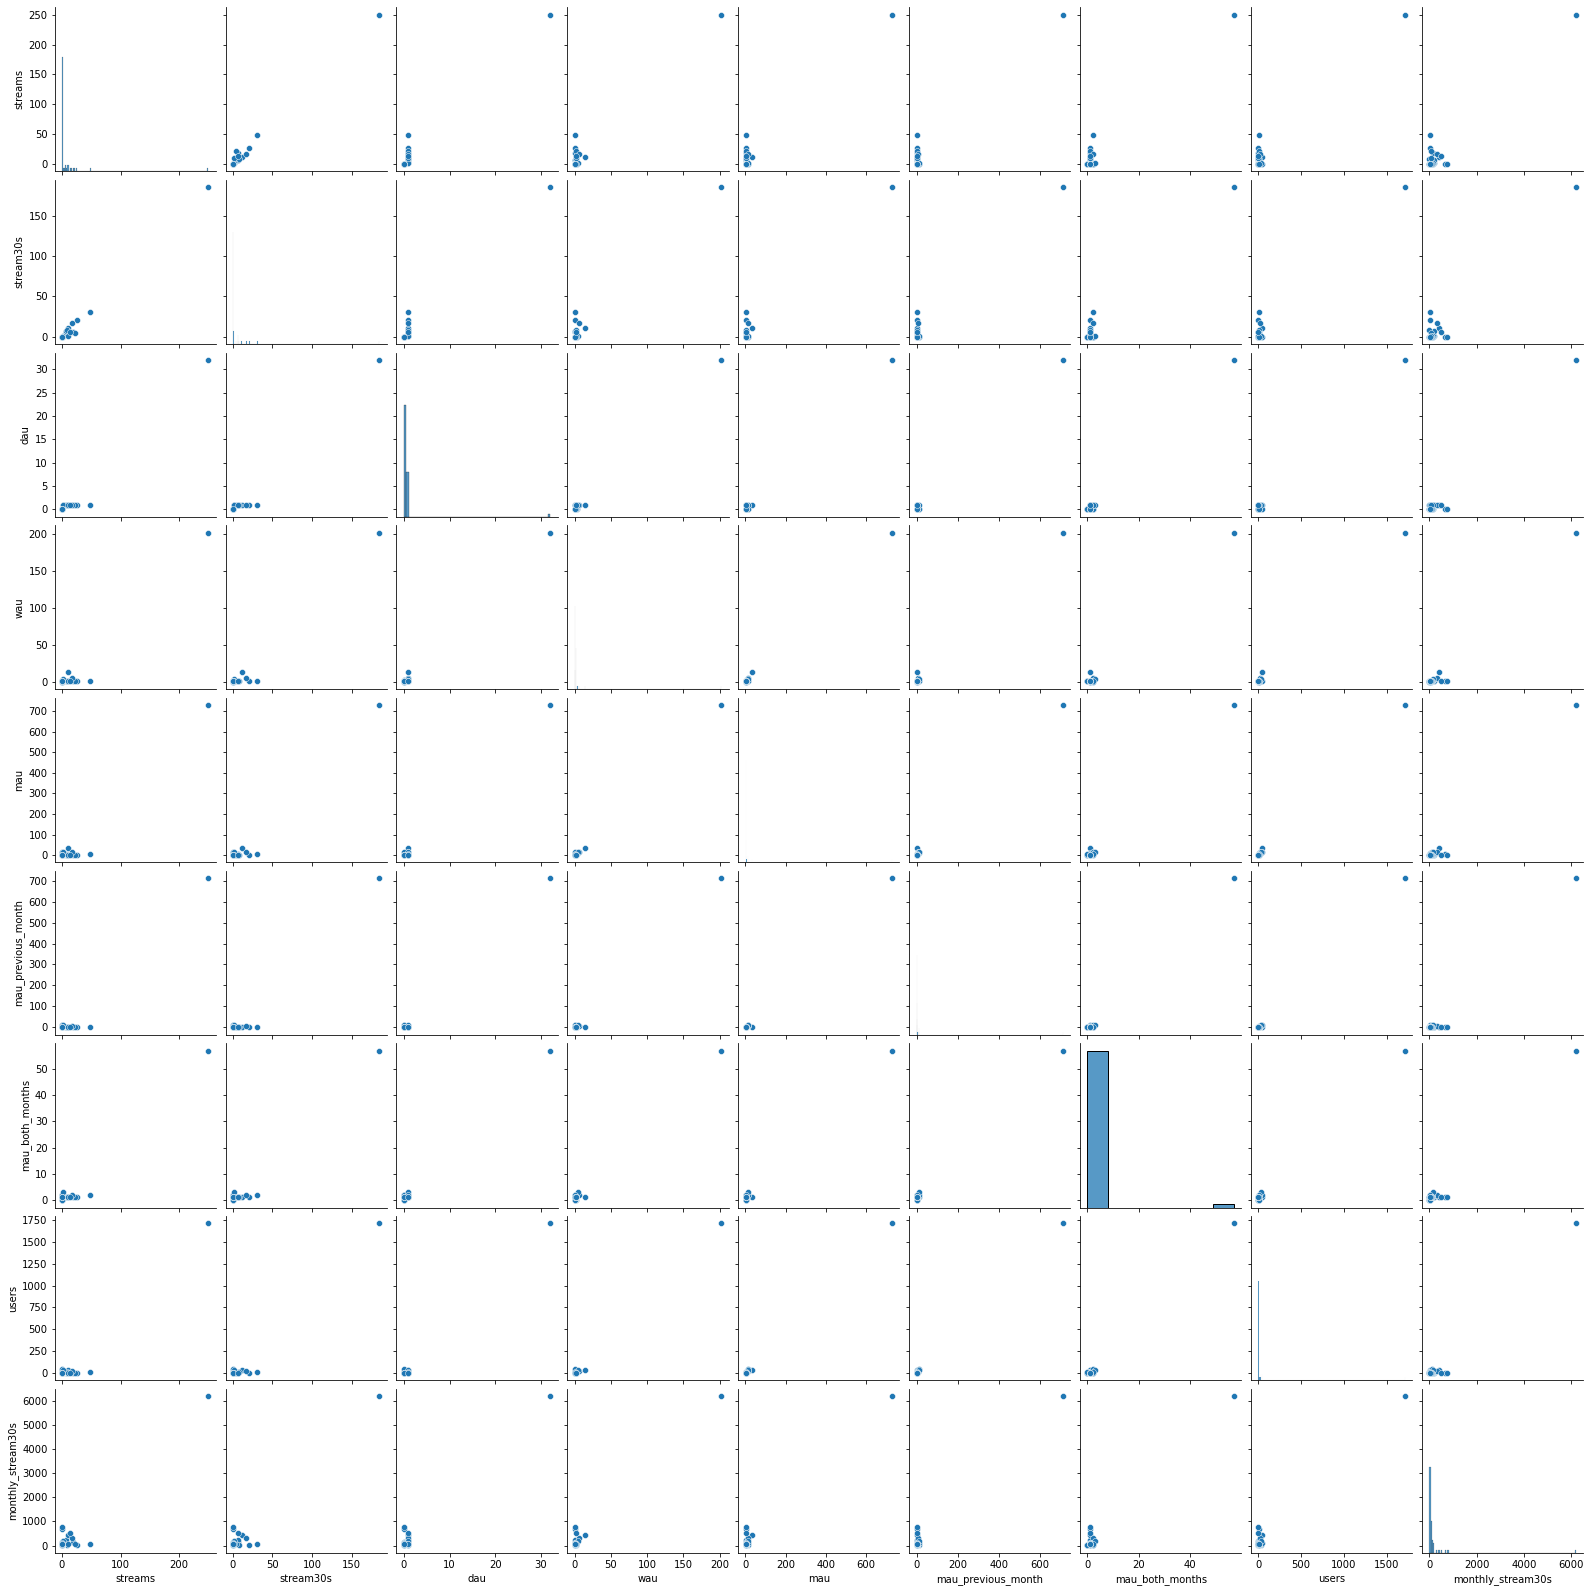

In [47]:
nonspotify_outcome_data_sample = nonspotify_outcome_data.sample(50)
sns.pairplot(nonspotify_outcome_data_sample)